In [1]:
!pip install pwlf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pwlf
import warnings

from scipy.interpolate import splev, splrep

%matplotlib inline

# Countries

## Data

In [3]:
owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', parse_dates=['date'])
owid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133292 entries, 0 to 133291
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    133292 non-null  object        
 1   continent                                   124779 non-null  object        
 2   location                                    133292 non-null  object        
 3   date                                        133292 non-null  datetime64[ns]
 4   total_cases                                 126031 non-null  float64       
 5   new_cases                                   126029 non-null  float64       
 6   new_cases_smoothed                          124986 non-null  float64       
 7   total_deaths                                114890 non-null  float64       
 8   new_deaths                                  115086 non-null  float64      

The correct way of taking the actual value of cumulative cases/deaths is to compute the latest date (for each country) first;
```
last_date = owid[['iso_code', 'date']].groupby('iso_code').max()
```
but **supposing there aren't** that many **errors**, the fact that they are cumulative functions simplifies the operation.

In [5]:
df_owid = owid[['iso_code', 'stringency_index', 'population', 'population_density']].groupby('iso_code').mean()
# monotonic increasing functions
df_owid['cases'] = owid[['iso_code', 'total_cases']].groupby('iso_code').max()
df_owid['deaths'] = owid[['iso_code', 'total_deaths']].groupby('iso_code').max()

df_owid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, ABW to ZWE
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stringency_index    182 non-null    float64
 1   population          235 non-null    float64
 2   population_density  208 non-null    float64
 3   cases               207 non-null    float64
 4   deaths              199 non-null    float64
dtypes: float64(5)
memory usage: 11.1+ KB


In [6]:
df_owid['prop_case'] = df_owid['cases'] / df_owid['population']
df_owid['prop_death'] = df_owid['deaths'] / df_owid['population']

## Visualization

In [7]:
# countries (and position in plot)

# cases
col_drop = ['population', 'population_density', 'deaths', 'prop_case', 'prop_death']

min_case = df_owid.sort_values(by='cases').drop(columns=col_drop).dropna().head()
min_case['iso_code'] = min_case.index
max_case = df_owid.sort_values(by='cases').drop(columns=col_drop).dropna().tail()
max_case['iso_code'] = max_case.index

# deaths
col_drop = ['population', 'population_density', 'cases', 'prop_case', 'prop_death']

min_death = df_owid.sort_values(by='deaths').drop(columns=col_drop).dropna().head()
min_death['iso_code'] = min_death.index
max_death = df_owid.sort_values(by='deaths').drop(columns=col_drop).dropna().tail()
max_death['iso_code'] = max_death.index

# proportions
col_drop = ['population', 'population_density', 'cases', 'deaths', 'prop_death']
max_propc = df_owid.sort_values(by='prop_case').drop(columns=col_drop).dropna().tail()
max_propc['iso_code'] = max_propc.index

col_drop = ['population', 'population_density', 'cases', 'deaths', 'prop_case']
max_propd = df_owid.sort_values(by='prop_death').drop(columns=col_drop).dropna().tail()
max_propd['iso_code'] = max_propd.index

# policy index
col_drop.pop()
max_ind = df_owid.sort_values(by='stringency_index').drop(columns=col_drop).dropna().tail()
max_ind['iso_code'] = max_ind.index

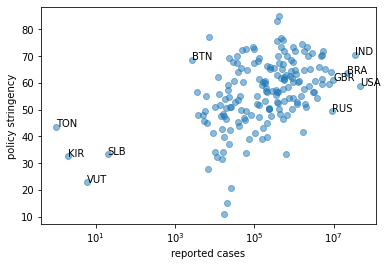

In [8]:
fig, ax = plt.subplots()
ax.semilogx(df_owid['cases'], df_owid['stringency_index'], 'o', alpha=0.5)
ax.set_xlabel('reported cases')
ax.set_ylabel('policy stringency')
# text annotations
for idx in min_case.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_case.values:
  ax.text(idx[1], idx[0], idx[2])
fig.show()

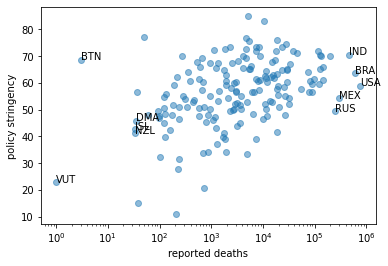

In [9]:
fig, ax = plt.subplots()
ax.semilogx(df_owid['deaths'], df_owid['stringency_index'], 'o', alpha=0.5)
ax.set_xlabel('reported deaths')
ax.set_ylabel('policy stringency')
# text annotations
for idx in min_death.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_death.values:
  ax.text(idx[1], idx[0], idx[2])
fig.show()

Problem with the different sizes in populations of the countries and with **underreporting** the number of cases and deaths in certain countries.


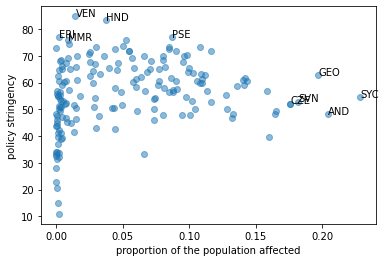

In [10]:
fig, ax = plt.subplots()
ax.scatter(df_owid['prop_case'], df_owid['stringency_index'], alpha=0.5)
ax.set_xlabel('proportion of the population affected')
ax.set_ylabel('policy stringency')
# text annotations
for idx in max_propc.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_ind.values:
  ax.text(idx[1], idx[0], idx[3])
fig.show()

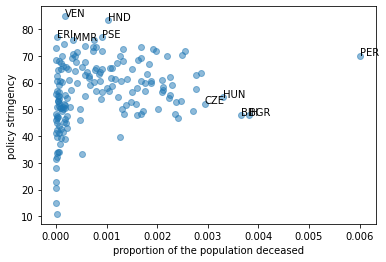

In [11]:
fig, ax = plt.subplots()
ax.scatter(df_owid['prop_death'], df_owid['stringency_index'], alpha=0.5)
ax.set_xlabel('proportion of the population deceased')
ax.set_ylabel('policy stringency')
# text annotations
for idx in max_propd.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_ind.values:
  ax.text(idx[2], idx[0], idx[3])
fig.show()

Consider **outliers**, possibly non representative values for countries on the bottom left of the plots.

## Selection

List of countries and corresponding ISO codes.

In [12]:
cc_dict = {k:v for k, v in zip(owid['iso_code'].unique(), owid['location'].unique())}
for iso in cc_dict:
  print(f'{iso:9} => {cc_dict[iso]}')

AFG       => Afghanistan
OWID_AFR  => Africa
ALB       => Albania
DZA       => Algeria
AND       => Andorra
AGO       => Angola
AIA       => Anguilla
ATG       => Antigua and Barbuda
ARG       => Argentina
ARM       => Armenia
ABW       => Aruba
OWID_ASI  => Asia
AUS       => Australia
AUT       => Austria
AZE       => Azerbaijan
BHS       => Bahamas
BHR       => Bahrain
BGD       => Bangladesh
BRB       => Barbados
BLR       => Belarus
BEL       => Belgium
BLZ       => Belize
BEN       => Benin
BMU       => Bermuda
BTN       => Bhutan
BOL       => Bolivia
BES       => Bonaire Sint Eustatius and Saba
BIH       => Bosnia and Herzegovina
BWA       => Botswana
BRA       => Brazil
VGB       => British Virgin Islands
BRN       => Brunei
BGR       => Bulgaria
BFA       => Burkina Faso
BDI       => Burundi
KHM       => Cambodia
CMR       => Cameroon
CAN       => Canada
CPV       => Cape Verde
CYM       => Cayman Islands
CAF       => Central African Republic
TCD       => Chad
CHL       => Chil

Locate a specific country (by ISO code).

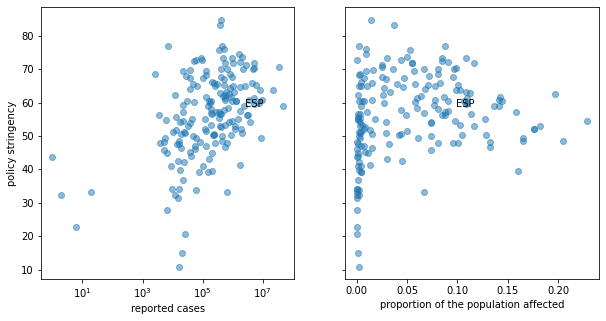

In [13]:
cc = 'ESP' # ISO code for the country

# plot
text_prop = {'va': 'center', 'ha': 'center'}

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axs[0].semilogx(df_owid['cases'], df_owid['stringency_index'], 'o', alpha=0.5)
axs[0].set_xlabel('reported cases')
axs[0].set_ylabel('policy stringency')
axs[0].text(
    df_owid.loc[cc, 'cases'], df_owid.loc[cc, 'stringency_index'], 
    cc, text_prop
)
axs[1].scatter(df_owid['prop_case'], df_owid['stringency_index'], alpha=0.5)
axs[1].set_xlabel('proportion of the population affected')
axs[1].text(
    df_owid.loc[cc, 'prop_case'], df_owid.loc[cc, 'stringency_index'], 
    cc, text_prop
)
fig.show()

Interesting final objectives for analysis. Potential targets.

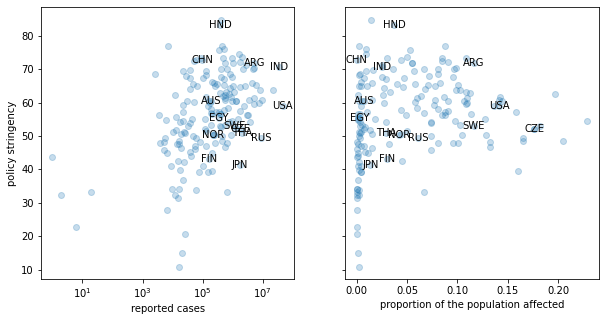

In [14]:
ccs = [ # country codes
       'ARG', 'AUS', 'CHN', 'CZE', 'EGY', 'FIN', 'HND', 
       'IND', 'JPN', 'NOR', 'RUS', 'SWE', 'THA', 'USA'
]

# plot
text_prop = {'va': 'center', 'ha': 'center'}

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axs[0].semilogx(df_owid['cases'], df_owid['stringency_index'], 'o', alpha=0.25)
axs[0].set_xlabel('reported cases')
axs[0].set_ylabel('policy stringency')
axs[1].scatter(df_owid['prop_case'], df_owid['stringency_index'], alpha=0.25)
axs[1].set_xlabel('proportion of the population affected')
for cc in ccs:
  axs[0].text(
      df_owid.loc[cc, 'cases'], df_owid.loc[cc, 'stringency_index'], 
      cc, text_prop
  )
  axs[1].text(
      df_owid.loc[cc, 'prop_case'], df_owid.loc[cc, 'stringency_index'], 
      cc, text_prop
  )
fig.show()

Issue with big (geographically speaking) countries. Explore ratio with respect to cities. May be more representative. It may not be a relevant issue however.

## Population

For a more reliable estimate of country population, we can extract the data from a direct source.

*It will be used later.*

In [15]:
cc_dict['CZE'] = 'Czech Republic'

In [16]:
# read_html() retrieves a list of dfs
pop_df = pd.read_html(
    'https://worldpopulationreview.com/countries', header=0, index_col=1
)[0].reindex(cc_dict.values())
pop_df.dropna(inplace=True)
pop_df

,Rank,2021 Population,2020 Population,Growth Rate,Area,Density (km²)
Country,,,,,,
Afghanistan,37.0,39835428.0,38928346.0,2.33%,652230.0,58/km²
Albania,140.0,2872933.0,2877797.0,-0.17%,28748.0,100/km²
Algeria,34.0,44616624.0,43851044.0,1.75%,2381741.0,18/km²
Andorra,202.0,77355.0,77265.0,0.12%,468.0,165/km²
Angola,45.0,33933610.0,32866272.0,3.25%,1246700.0,26/km²
...,...,...,...,...,...,...
Venezuela,50.0,28704954.0,28435940.0,0.95%,916445.0,31/km²
Vietnam,15.0,98168833.0,97338579.0,0.85%,331212.0,291/km²
Yemen,48.0,30490640.0,29825964.0,2.23%,527968.0,55/km²


# Policies

## Data

In [17]:
oxcgrt = pd.read_csv(
    'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv',
    dtype={'RegionName': str, 'RegionCode': str} # avoid error warning
)
oxcgrt.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True) # region information

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']    # only national status

oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127410 entries, 0 to 213719
Data columns (total 49 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            127410 non-null  object        
 1   CountryCode                            127410 non-null  object        
 2   Jurisdiction                           127410 non-null  object        
 3   Date                                   127410 non-null  datetime64[ns]
 4   C1_School closing                      125327 non-null  float64       
 5   C1_Flag                                96952 non-null   float64       
 6   C2_Workplace closing                   125284 non-null  float64       
 7   C2_Flag                                93470 non-null   float64       
 8   C3_Cancel public events                125323 non-null  float64       
 9   C3_Flag                                99848 non

Range of time available.

In [19]:
print(oxcgrt['Date'].min(), '<--->', oxcgrt['Date'].max())
print(oxcgrt['Date'].max() - oxcgrt['Date'].min())

2020-01-01 00:00:00 <---> 2021-11-15 00:00:00
684 days 00:00:00


### Pivoting

In [20]:
stringent = oxcgrt.pivot(index='Date', columns='CountryCode', values='StringencyIndex')
stringent.head()

CountryCode,ABW,AFG,AGO,ALB,AND,ARE,ARG,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BLZ,BMU,BOL,BRA,BRB,BRN,BTN,BWA,CAF,CAN,CHE,CHL,CHN,CIV,CMR,COD,COG,COL,COM,CPV,...,SGP,SLB,SLE,SLV,SMR,SOM,SRB,SSD,SUR,SVK,SVN,SWE,SWZ,SYC,SYR,TCD,TGO,THA,TJK,TKM,TLS,TON,TTO,TUN,TUR,TWN,TZA,UGA,UKR,URY,USA,UZB,VEN,VIR,VNM,VUT,YEM,ZAF,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,5.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.56,0.0,0.0,0.0,0.0,2.78,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,19.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
cases = oxcgrt.pivot(index='Date', columns='CountryCode', values='ConfirmedCases')
cases[50:55] # first values are NA

CountryCode,ABW,AFG,AGO,ALB,AND,ARE,ARG,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BLZ,BMU,BOL,BRA,BRB,BRN,BTN,BWA,CAF,CAN,CHE,CHL,CHN,CIV,CMR,COD,COG,COL,COM,CPV,...,SGP,SLB,SLE,SLV,SMR,SOM,SRB,SSD,SUR,SVK,SVN,SWE,SWZ,SYC,SYR,TCD,TGO,THA,TJK,TKM,TLS,TON,TTO,TUN,TUR,TWN,TZA,UGA,UKR,URY,USA,UZB,VEN,VIR,VNM,VUT,YEM,ZAF,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-20,0.0,0.0,0.0,0.0,0.0,9.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,74999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-21,0.0,0.0,0.0,0.0,0.0,9.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,75472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-22,0.0,0.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,76922.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,2.0,76938.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-24,0.0,5.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,2.0,77152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0


In [22]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

## Selection

### Policies

Correlation of the different containment policy types. Can be used to supress highly correlated policies.

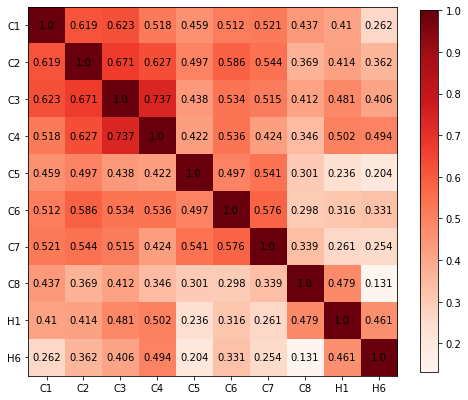

In [23]:
mask = oxcgrt['CountryCode'].isin(cc_dict)
corr = oxcgrt.loc[mask, idch].corr()

# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=corr, cmap='Reds') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# show all ticks...
ax.set_xticks(range(corr.shape[1]))
ax.set_yticks(range(corr.shape[0]))
# ...and label them
ax.set_xticklabels([s.split('_')[0] for s in corr.columns])
ax.set_yticklabels([s.split('_')[0] for s in corr.index])
# loop over data dimensions and create text annotations
for i in range(corr.shape[1]):
  for j in range(corr.shape[0]):
    text = ax.text(j, i, round(corr.iloc[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

Insufficient correlation to supress any of them safely.

* Only the pair (C3, C4) has a correlation above 0.7.
* Among the tuple (C1, C2, C3, C4), most combinations are correlated above 0.6.

### Countries

The chosen types of policy have flags that contain geographic scope. The possible values are:
- 0: targeted
- 1: general

In [24]:
flag_idx = list(oxcgrt.columns[1:18:2]) # CX flag
flag_idx.append(oxcgrt.columns[25])     # H1 flag
flag_idx.append(oxcgrt.columns[31])     # H6 flag

In [25]:
oxcgrt.loc[oxcgrt['CountryCode'].isin(ccs), flag_idx].groupby('CountryCode').mean()

,C1_Flag,C2_Flag,C3_Flag,C4_Flag,C5_Flag,C6_Flag,C7_Flag,H1_Flag,H6_Flag
CountryCode,,,,,,,,,
ARG,0.627258,0.166667,0.910423,0.671617,0.332226,0.128713,0.361983,1.000000,1.000000
AUS,0.107527,0.078859,0.191667,0.120000,0.000000,0.146699,0.147404,1.000000,0.191268
CHN,0.188361,0.075038,0.031963,0.010654,0.405975,0.082935,0.103876,0.970326,0.669617
CZE,0.923577,0.841762,1.000000,0.956169,0.081395,1.000000,0.488449,0.951662,0.898026
EGY,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FIN,0.650582,0.540902,0.529204,0.358974,NaN,0.647783,0.756757,1.000000,0.690949
HND,0.851064,1.000000,1.000000,1.000000,1.000000,0.948675,1.000000,1.000000,1.000000
IND,0.304560,0.075410,0.404187,0.067545,0.341253,0.154545,0.224417,1.000000,0.507589
JPN,0.782609,0.262327,0.741680,0.458333,0.882353,0.868821,0.665546,1.000000,1.000000


In [26]:
oxcgrt.loc[oxcgrt['CountryCode'].isin(ccs), flag_idx].groupby('CountryCode').mean().mean(axis=1)

CountryCode
ARG    0.577654
AUS    0.220380
CHN    0.282083
CZE    0.793449
EGY    1.000000
FIN    0.646894
HND    0.977749
IND    0.342167
JPN    0.740186
NOR    0.868858
RUS    0.306068
SWE    0.872210
THA    0.615697
USA    0.192173
dtype: float64

It would be ideal to feed the model countries that apply the same policies to all its territory (becauses the analysis is at national level).

In [27]:
avg_scope = oxcgrt[flag_idx].groupby('CountryCode').mean().mean(axis=1)
idx_sorted = np.argsort(avg_scope.values)
sorted = avg_scope.iloc[idx_sorted[:-1]][::-1]
sorted.drop(labels=['VIR', 'GUM', 'RKS', 'PRI'], axis=0, inplace=True)
sorted

CountryCode
BRB    1.000000
HKG    1.000000
SMR    1.000000
SWZ    1.000000
LSO    1.000000
         ...   
CHN    0.282083
AUS    0.220380
CAN    0.214440
USA    0.192173
BRA    0.160323
Length: 181, dtype: float64

But the countries also need to be big enough so that the analysis is statistically significant.

In [28]:
pop_min = 10**7
populated = owid.groupby('iso_code').mean()['population'] > pop_min
populated = populated[sorted.index]
selected = sorted[populated].head(15)
selected

CountryCode
EGY    1.000000
MLI    1.000000
NLD    0.991916
MWI    0.991118
ZAF    0.990756
ZWE    0.990401
JOR    0.981041
DOM    0.979929
POL    0.978420
HND    0.977749
CMR    0.967829
SSD    0.966660
HTI    0.954693
ZMB    0.954655
BEL    0.935210
dtype: float64

In [29]:
{k:cc_dict[k] for k in selected.index}

{'BEL': 'Belgium',
 'CMR': 'Cameroon',
 'DOM': 'Dominican Republic',
 'EGY': 'Egypt',
 'HND': 'Honduras',
 'HTI': 'Haiti',
 'JOR': 'Jordan',
 'MLI': 'Mali',
 'MWI': 'Malawi',
 'NLD': 'Netherlands',
 'POL': 'Poland',
 'SSD': 'South Sudan',
 'ZAF': 'South Africa',
 'ZMB': 'Zambia',
 'ZWE': 'Zimbabwe'}

## Visualization

Time relationship between the number of cases and the moment policies were implemented.

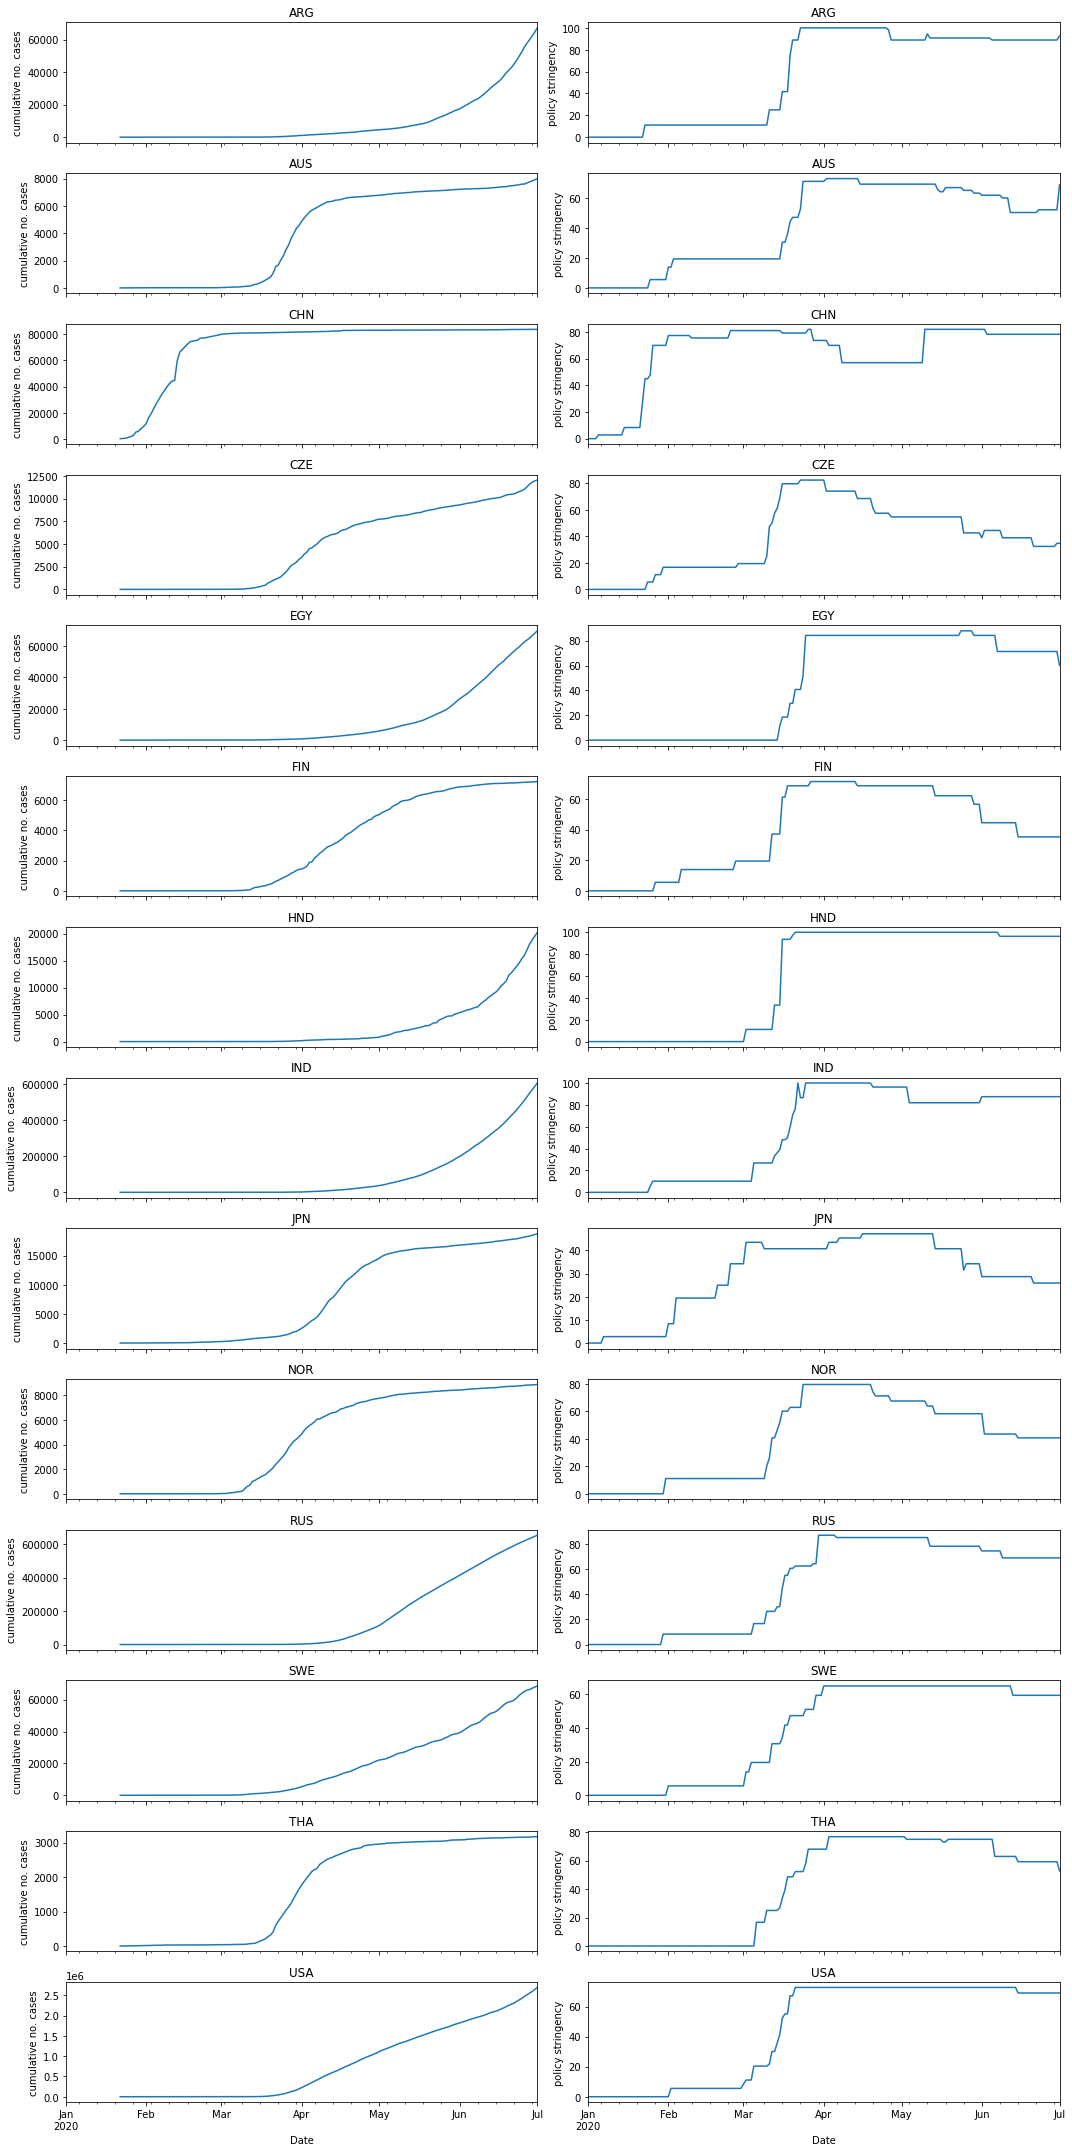

In [30]:
nrows = len(ccs)
ncols = 2
t0, t1 = '2020-01-01', '2020-07-01'

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 30))
for i in range(nrows):
  cases.loc[t0:t1, ccs[i]].plot(ax=axs[i, 0])
  stringent.loc[t0:t1, ccs[i]].plot(ax=axs[i, 1])
  axs[i, 0].set_title(ccs[i])
  axs[i, 1].set_title(ccs[i])
  axs[i, 0].set_ylabel('cumulative no. cases')
  axs[i, 1].set_ylabel('policy stringency')
fig.tight_layout()
fig.show()

Implementation time of different (containment) policies.

In [31]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


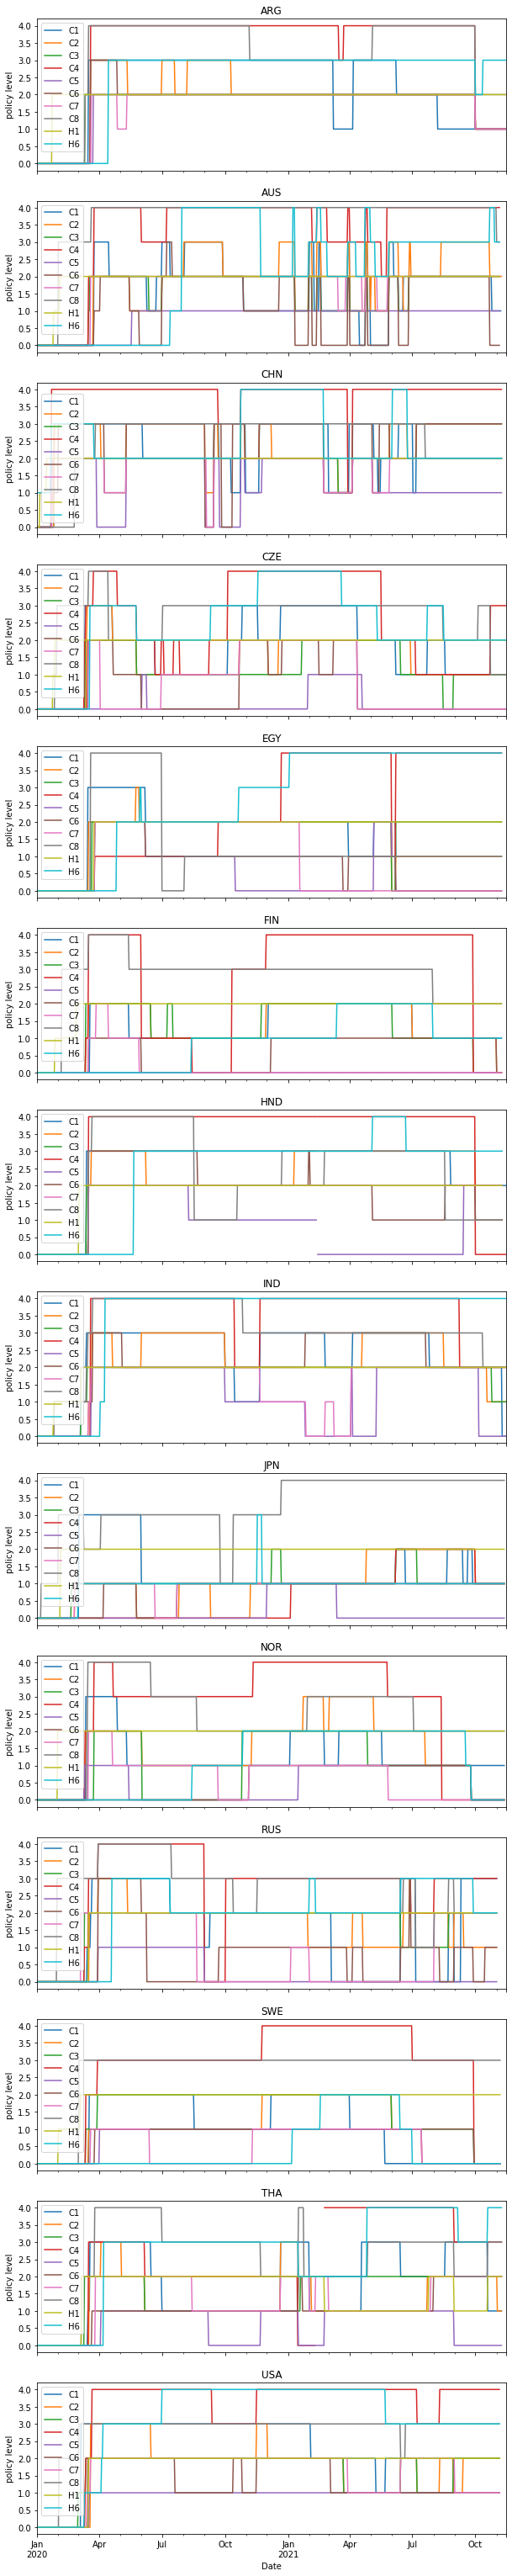

In [32]:
fig, axs = plt.subplots(nrows=nrows, sharex=True, figsize=(10, 55))
for i in range(nrows):
  # policy indicators
  C1[ccs[i]].plot(ax=axs[i])
  C2[ccs[i]].plot(ax=axs[i])
  C3[ccs[i]].plot(ax=axs[i])
  C4[ccs[i]].plot(ax=axs[i])
  C5[ccs[i]].plot(ax=axs[i])
  C6[ccs[i]].plot(ax=axs[i])
  C7[ccs[i]].plot(ax=axs[i])
  C8[ccs[i]].plot(ax=axs[i])
  H1[ccs[i]].plot(ax=axs[i])
  H6[ccs[i]].plot(ax=axs[i])
  # labels
  axs[i].set_title(ccs[i])
  axs[i].set_ylabel('policy level')
  axs[i].legend([s.split('_')[0] for s in idch])
fig.show()

# Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

## Data

In [33]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [34]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(280, 667)

In [35]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(280, 667)

In [36]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(265, 667)

### Area level reporting

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [37]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21,10/13/21,10/14/21,10/15/21,10/16/21,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21,11/12/21,11/13/21,11/14/21
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1231,1271,1296,1326,1358,1386,1437,1483,1518,1538,1571,1588,1612,1636,1664,1677,1701,1710,1719,1731,1741,1749,1759,1768,1775,1780,1788,1803,1816,1822,1840,1853,1866,1884,1893,1902,1917,1928,1943,1953
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,67024,67669,68246,68712,69205,69552,69993,70391,70781,71099,71399,71658,71923,72202,72560,72899,73212,73500,73785,74057,74362,74634,74887,75112,75278,75407,75578,75766,76073,76314,76580,76824,76988,77207,77417,77671,77951,78200,78393,78556
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,212,213,214,214,215,215,216,222,222,224,225,225,225,225,225,225,225,225,225,225,225,225,225,225,225,225,225,225,226,227,228,229,229,230,230,231,231,231,232,231
11,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,2056,2056,2059,2062,2063,2067,2067,2067,2068,2071,2071,2071,2071,2072,2077,2082,2082,2082,2082,2085,2086,2087,2089,2089,2089,2090,2090,2089,2092,2094,2095,2098,2098,2099,2102,2105,2109,2106,2106,2109
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,907,907,908,909,910,913,914,914,914,914,915,915,915,916,916,917,917,917,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,919,920,920
13,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,236,236,236,236,236,236,236,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,237,238
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,47266,49104,51012,52902,54470,55936,57470,59763,61869,63836,65674,67457,69206,70998,73151,75340,76886,78763,80152,81651,83185,84942,86563,87918,88930,90261,91217,92126,93339,94669,95917,97043,98130,99183,100162,101451,102566,103760,104665,105484
15,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1110,1110,1110,1110,1110,1110,1111,1111,1111,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112


In [38]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21,10/13/21,10/14/21,10/15/21,10/16/21,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21,11/12/21,11/13/21,11/14/21
193,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15578,15587,15605,15626,15626,15645,15663,15663,15692,15702,15715,15720,15732,15746,15765,15779,15790,15800,15807,15815,15848,15865,15882,15901,15916,15925,15931,15937,15949,15965,15981,15997,16006,16011,16011,16039,16057,16071,16076,16083
194,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2184,2204,2217,2217,2235,2257,2274,2290,2306,2312,2325,2335,2341,2353,2365,2373,2379,2383,2388,2390,2402,2407,2411,2417,2432,2435,2444,2455,2455,2468,2485,2494,2501,2511,2522,2546,2584,2597,2616,2628
195,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16684,16704,16742,16777,16787,16804,16837,16866,16885,16899,16921,16934,16936,16955,16972,16984,16998,17002,17011,17012,17027,17047,17053,17062,17072,17084,17091,17100,17111,17123,17134,17146,17156,17162,17162,17176,17187,17197,17216,17225
196,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4355,4386,4395,4395,4403,4403,4420,4431,4438,4439,4444,4444,4448,4456,4467,4468,4472,4478,4478,4480,4484,4486,4488,4492,4494,4494,4498,4501,4501,4501,4509,4509,4510,4517,4517,4526,4526,4526,4532,4532
197,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2013425,2016171,2018932,2021433,2023691,2026402,2029289,2033005,2036628,2040337,2044039,2047711,2051065,2054960,2059534,2064729,2070597,2076273,2082563,2087859,2093606,2100866,2108549,2115938,2123880,2132052,2139746,2147473,2156582,2166796,2177707,2189661,2201010,2212814,2224096,2236744,2253031,2269235,2283083,2295107


Canada does not have recovery data available at province-level.

In [39]:
jhu_cases['Country/Region'].value_counts().head(9)

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Tonga              1
Name: Country/Region, dtype: int64

In [40]:
jhu_death['Country/Region'].value_counts().head(9)

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Tonga              1
Name: Country/Region, dtype: int64

In [41]:
jhu_recov['Country/Region'].value_counts().head(9)

China             34
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Tonga              1
India              1
Name: Country/Region, dtype: int64

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [42]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (276, 664)
deaths shape: (276, 664)
recoveries shape: (261, 664)


In [43]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (663, 196)
deaths shape: (663, 196)
recoveries shape: (663, 196)


### Compartment variables

To prepare data to input into models:

1. Restrict the country dictionary to a previously selected subset. Do the same with the population data-frame.
1. Create separate dataframes containing data on countries of interest only.
1. Apply a smoothing average to the curves.
1. Use them to compute further variables (compartments) needed to represent the compartmental model.

In [44]:
cc_dict = {cc : cc_dict[cc] for cc in ccs}
cc_dict

{'ARG': 'Argentina',
 'AUS': 'Australia',
 'CHN': 'China',
 'CZE': 'Czech Republic',
 'EGY': 'Egypt',
 'FIN': 'Finland',
 'HND': 'Honduras',
 'IND': 'India',
 'JPN': 'Japan',
 'NOR': 'Norway',
 'RUS': 'Russia',
 'SWE': 'Sweden',
 'THA': 'Thailand',
 'USA': 'United States'}

In [45]:
pop_df = pop_df.loc[cc_dict.values(), '2020 Population']
pop_df = pop_df.convert_dtypes(int)
pop_df

Country
Argentina           45195774
Australia           25499884
China             1439323776
Czech Republic      10708981
Egypt              102334404
Finland              5540720
Honduras             9904607
India             1380004385
Japan              126476461
Norway               5421241
Russia             145934462
Sweden              10099265
Thailand            69799978
United States      331002651
Name: 2020 Population, dtype: Int64

In [46]:
# TypeError: Index does not support mutable operations
# create a population dictionary
pop_dict = {cc : pop_df[cc_dict[cc]] for cc in ccs}
pop_dict

{'ARG': 45195774,
 'AUS': 25499884,
 'CHN': 1439323776,
 'CZE': 10708981,
 'EGY': 102334404,
 'FIN': 5540720,
 'HND': 9904607,
 'IND': 1380004385,
 'JPN': 126476461,
 'NOR': 5421241,
 'RUS': 145934462,
 'SWE': 10099265,
 'THA': 69799978,
 'USA': 331002651}

In [47]:
# diff value in diff df
cc_dict['USA'] = 'US'
cc_dict['CZE'] = 'Czechia'

In [48]:
window = 7

In [49]:
cum_cases = jhu_cases[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_cases

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.000000,879.250000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.750000e+00,1.500000e+00
2020-01-23,0.000000e+00,0.800000,1118.400000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.400000e+00,0.000000,0.000000e+00,0.000000e+00,5.400000e+00,2.200000e+00
2020-01-24,0.000000e+00,1.500000,1411.500000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.666667e+00,0.000000,0.000000e+00,0.000000e+00,5.833333e+00,2.666667e+00
2020-01-25,0.000000e+00,2.000000,1996.857143,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,3.285714e+00,0.000000,0.000000e+00,0.000000e+00,7.000000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.857143,2788.142857,0.000000e+00,0.000000,0.142857,0.000000,0.000000e+00,4.000000e+00,0.000000,0.000000e+00,0.000000e+00,8.428571e+00,3.714286e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,5.300987e+06,185612.571429,110477.000000,1.844501e+06,340259.142857,165697.571429,376683.285714,3.440170e+07,1.724190e+06,222255.285714,8.766107e+06,1.180053e+06,1.989733e+06,4.678559e+07
2021-11-11,5.302267e+06,186901.857143,110549.142857,1.855107e+06,341050.714286,166360.857143,376781.285714,3.441320e+07,1.724363e+06,223922.571429,8.804302e+06,1.180821e+06,1.996935e+06,4.686765e+07
2021-11-12,5.302967e+06,187573.833333,110585.666667,1.861099e+06,341490.166667,166672.333333,376812.333333,3.441922e+07,1.724460e+06,224845.166667,8.823383e+06,1.181442e+06,2.000492e+06,4.690948e+07
2021-11-13,5.303676e+06,188274.400000,110625.800000,1.867631e+06,341921.200000,166946.400000,376839.600000,3.442535e+07,1.724557e+06,225711.600000,8.842496e+06,1.181893e+06,2.004091e+06,4.695206e+07


In [50]:
cum_deaths = jhu_death[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,31.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,40.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,53.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,69.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,116179.285714,1860.000000,4849.000000,31221.714286,19250.142857,1208.142857,10334.000000,462278.428571,18314.571429,937.428571,245806.571429,15071.000000,19823.285714,759095.285714
2021-11-11,116197.571429,1868.714286,4849.000000,31287.285714,19301.428571,1212.142857,10340.285714,462649.571429,18317.000000,941.428571,247002.000000,15074.571429,19876.428571,760252.714286
2021-11-12,116206.666667,1873.333333,4849.000000,31326.333333,19330.000000,1214.166667,10345.000000,462859.666667,18318.333333,944.833333,247601.500000,15077.500000,19905.333333,760924.833333
2021-11-13,116215.000000,1876.400000,4849.000000,31357.000000,19358.800000,1215.200000,10347.000000,463061.800000,18319.600000,949.000000,248204.200000,15080.000000,19933.600000,761579.600000


In [51]:
cum_recoveries = jhu_recov[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.0,0.0,33.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.500000,0.0
2020-01-23,0.0,0.0,36.400000,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,3.200000,0.0
2020-01-24,0.0,0.0,40.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,3.666667,0.0
2020-01-25,0.0,0.0,48.714286,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.0,0.0,4.000000,0.0
2020-01-26,0.0,0.0,61.857143,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.0,0.0,4.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2021-11-11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2021-11-12,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2021-11-13,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [52]:
R = cum_deaths + cum_recoveries
R

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000
2020-01-23,0.000000,0.000000,68.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,3.200000,0.000000
2020-01-24,0.000000,0.000000,80.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,3.666667,0.000000
2020-01-25,0.000000,0.000000,101.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,4.000000,0.000000
2020-01-26,0.000000,0.000000,131.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.000000,0.000000,0.000000,4.571429,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,116179.285714,1860.000000,4849.000000,31221.714286,19250.142857,1208.142857,10334.000000,462278.428571,18314.571429,937.428571,245806.571429,15071.000000,19823.285714,759095.285714
2021-11-11,116197.571429,1868.714286,4849.000000,31287.285714,19301.428571,1212.142857,10340.285714,462649.571429,18317.000000,941.428571,247002.000000,15074.571429,19876.428571,760252.714286
2021-11-12,116206.666667,1873.333333,4849.000000,31326.333333,19330.000000,1214.166667,10345.000000,462859.666667,18318.333333,944.833333,247601.500000,15077.500000,19905.333333,760924.833333
2021-11-13,116215.000000,1876.400000,4849.000000,31357.000000,19358.800000,1215.200000,10347.000000,463061.800000,18319.600000,949.000000,248204.200000,15080.000000,19933.600000,761579.600000


In [53]:
I = cum_cases - R
I

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.000000,820.250000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.250000e+00,1.500000e+00
2020-01-23,0.000000e+00,0.800000,1050.200000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.200000e+00,0.000000,0.000000e+00,0.000000e+00,2.200000e+00,2.200000e+00
2020-01-24,0.000000e+00,1.500000,1331.333333,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.333333e+00,0.000000,0.000000e+00,0.000000e+00,2.166667e+00,2.666667e+00
2020-01-25,0.000000e+00,2.000000,1895.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.857143e+00,0.000000,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.857143,2656.571429,0.000000e+00,0.000000,0.142857,0.000000,0.000000e+00,3.428571e+00,0.000000,0.000000e+00,0.000000e+00,3.857143e+00,3.714286e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,5.184808e+06,183752.571429,105628.000000,1.813279e+06,321009.000000,164489.428571,366349.285714,3.393942e+07,1.705876e+06,221317.857143,8.520301e+06,1.164982e+06,1.969910e+06,4.602650e+07
2021-11-11,5.186069e+06,185033.142857,105700.142857,1.823820e+06,321749.285714,165148.714286,366441.000000,3.395055e+07,1.706046e+06,222981.142857,8.557300e+06,1.165747e+06,1.977058e+06,4.610739e+07
2021-11-12,5.186760e+06,185700.500000,105736.666667,1.829773e+06,322160.166667,165458.166667,366467.333333,3.395636e+07,1.706142e+06,223900.333333,8.575781e+06,1.166365e+06,1.980587e+06,4.614856e+07
2021-11-13,5.187461e+06,186398.000000,105776.800000,1.836274e+06,322562.400000,165731.200000,366492.600000,3.396229e+07,1.706237e+06,224762.600000,8.594292e+06,1.166813e+06,1.984158e+06,4.619048e+07


In [54]:
S = pop_dict.values() - cum_cases
S

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,4.519577e+07,2.549988e+07,1.439323e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-23,4.519577e+07,2.549988e+07,1.439323e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-24,4.519577e+07,2.549988e+07,1.439322e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-25,4.519577e+07,2.549988e+07,1.439322e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-26,4.519577e+07,2.549988e+07,1.439321e+09,1.070898e+07,1.023344e+08,5.540720e+06,9.904607e+06,1.380004e+09,1.264765e+08,5.421241e+06,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,3.989479e+07,2.531427e+07,1.439213e+09,8.864480e+06,1.019941e+08,5.375022e+06,9.527924e+06,1.345603e+09,1.247523e+08,5.198986e+06,1.371684e+08,8.919212e+06,6.781024e+07,2.842171e+08
2021-11-11,3.989351e+07,2.531298e+07,1.439213e+09,8.853874e+06,1.019934e+08,5.374359e+06,9.527826e+06,1.345591e+09,1.247521e+08,5.197318e+06,1.371302e+08,8.918444e+06,6.780304e+07,2.841350e+08
2021-11-12,3.989281e+07,2.531231e+07,1.439213e+09,8.847882e+06,1.019929e+08,5.374048e+06,9.527795e+06,1.345585e+09,1.247520e+08,5.196396e+06,1.371111e+08,8.917822e+06,6.779949e+07,2.840932e+08
2021-11-13,3.989210e+07,2.531161e+07,1.439213e+09,8.841350e+06,1.019925e+08,5.373774e+06,9.527767e+06,1.345579e+09,1.247519e+08,5.195529e+06,1.370920e+08,8.917372e+06,6.779589e+07,2.840506e+08


Proportional compartments.

In [55]:
r_prop = R / pop_dict.values()
i_prop = I / pop_dict.values()
s_prop = S / pop_dict.values()

In [56]:
r_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.000000,4.099147e-08,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.581663e-08,0.000000
max,0.103704,0.000982,7.225149e-05,0.156032,0.002417,0.00848,0.010988,0.022669,0.006756,0.003467,0.039143,0.001493,4.567848e-04,0.019045


In [57]:
i_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.000000,7.324868e-08,0.000000,0.000000,0.000000,0.000000,0.000000,1.581322e-08,0.000000,0.000000,0.000000,3.104108e-08,4.531686e-09
max,0.114792,0.007336,7.352046e-05,0.172042,0.003156,0.029942,0.037006,0.024614,1.349130e-02,0.041617,0.059021,0.115568,2.847831e-02,1.396656e-01


In [58]:
s_prop.agg(['min', 'max'])

,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.882636,0.992591,0.999923,0.825027,0.996655,0.969838,0.961949,0.97505,0.986364,0.958208,0.939275,0.882938,0.971236,0.858032
max,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Labels

### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $gr=\log{i_2}-\log{i_1}=\beta-\gamma$.

In [59]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,-14.377830,0.000000,0.000000,0.000000,0.000000,0.000000,-17.962420,0.000000,0.000000,0.000000,-17.250214,-19.212172
2020-01-23,0.000000,-17.277328,-14.130703,0.000000,0.000000,0.000000,0.000000,0.000000,-17.867109,0.000000,0.000000,0.000000,-17.272687,-18.829180
2020-01-24,0.000000,-16.648719,-13.893503,0.000000,0.000000,0.000000,0.000000,0.000000,-17.808269,0.000000,0.000000,0.000000,-17.287954,-18.636808
2020-01-25,0.000000,-16.361037,-13.540465,0.000000,0.000000,0.000000,0.000000,0.000000,-17.605745,0.000000,0.000000,0.000000,-16.962532,-18.519025
2020-01-26,0.000000,-16.004362,-13.202648,0.000000,0.000000,-17.473545,0.000000,0.000000,-17.423423,0.000000,0.000000,0.000000,-16.711218,-18.305451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,-2.165271,-4.932839,-9.519760,-1.775946,-5.764532,-3.517033,-3.297168,-3.705265,-4.305978,-3.198480,-2.840706,-2.159757,-3.567646,-1.972909
2021-11-11,-2.165028,-4.925894,-9.519078,-1.770149,-5.762229,-3.513033,-3.296918,-3.704937,-4.305878,-3.190993,-2.836373,-2.159101,-3.564024,-1.971153
2021-11-12,-2.164894,-4.922294,-9.518732,-1.766891,-5.760952,-3.511161,-3.296846,-3.704766,-4.305822,-3.186879,-2.834216,-2.158571,-3.562241,-1.970261
2021-11-13,-2.164759,-4.918545,-9.518353,-1.763344,-5.759705,-3.509513,-3.296777,-3.704591,-4.305766,-3.183035,-2.832059,-2.158187,-3.560439,-1.969353


In [60]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,-17.277328,0.247127,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,0.000000,0.000000,0.000000,-0.022473,0.382992
2020-01-24,0.000000,0.628609,0.237200,0.000000,0.000000,0.000000,0.000000,0.000000,0.058841,0.000000,0.000000,0.000000,-0.015267,0.192372
2020-01-25,0.000000,0.287682,0.353038,0.000000,0.000000,0.000000,0.000000,0.000000,0.202524,0.000000,0.000000,0.000000,0.325422,0.117783
2020-01-26,0.000000,0.356675,0.337818,0.000000,0.000000,-17.473545,0.000000,0.000000,0.182322,0.000000,0.000000,0.000000,0.251314,0.213574
2020-01-27,0.000000,0.300105,0.328822,0.000000,0.000000,0.693147,0.000000,-22.991263,0.287682,0.000000,0.000000,0.000000,0.169899,0.175891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,0.000243,0.007199,0.000733,0.005559,0.002683,0.004016,0.000214,0.000333,0.000103,0.007441,0.004360,0.000657,0.003699,0.001789
2021-11-11,0.000243,0.006945,0.000683,0.005796,0.002303,0.004000,0.000250,0.000328,0.000100,0.007487,0.004333,0.000656,0.003622,0.001756
2021-11-12,0.000133,0.003600,0.000345,0.003258,0.001276,0.001872,0.000072,0.000171,0.000056,0.004114,0.002157,0.000530,0.001783,0.000892
2021-11-13,0.000135,0.003749,0.000379,0.003547,0.001248,0.001649,0.000069,0.000174,0.000056,0.003844,0.002156,0.000384,0.001801,0.000908


### Transmission coefficient computation

Operate with the relative compartments to save operations. Only assuming independence with time (same as last time), study $\beta=\frac{gr+\gamma}{s}=\frac{(\log{i_2}-\log{i_1})+\gamma}{s}$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [61]:
dr_dt = r_prop[1:] - r_prop[:-1].values # different index
dr_dt

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000e+00,0.000000e+00,6.391891e-09,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.581322e-09,0.000000e+00,0.000000,0.000000e+00,1.002866e-08,0.000000
2020-01-24,0.000000e+00,0.000000e+00,8.314089e-09,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.054215e-09,0.000000e+00,0.000000,0.000000e+00,6.685771e-09,0.000000
2020-01-25,0.000000e+00,0.000000e+00,1.506991e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.530104e-10,0.000000e+00,0.000000,0.000000e+00,4.775551e-09,0.000000
2020-01-26,0.000000e+00,0.000000e+00,2.064462e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.129516e-09,0.000000e+00,0.000000,0.000000e+00,8.186658e-09,0.000000
2020-01-27,0.000000e+00,1.120453e-08,2.560726e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.129516e-09,0.000000e+00,0.000000,0.000000e+00,1.023332e-08,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,4.330367e-07,3.753518e-07,0.000000e+00,0.000006,5.918970e-07,7.219278e-07,6.057787e-07,2.835395e-07,1.694273e-08,7.378384e-07,0.000008,3.536325e-07,7.736392e-07,0.000003
2021-11-11,4.045890e-07,3.417382e-07,0.000000e+00,0.000006,5.011581e-07,7.219278e-07,6.346253e-07,2.689432e-07,1.920177e-08,7.378384e-07,0.000008,3.536325e-07,7.613592e-07,0.000003
2021-11-12,2.012409e-07,1.811399e-07,0.000000e+00,0.000004,2.791967e-07,3.652611e-07,4.759690e-07,1.522424e-07,1.054215e-08,6.280411e-07,0.000004,2.899787e-07,4.141085e-07,0.000002
2021-11-13,1.843830e-07,1.202620e-07,0.000000e+00,0.000003,2.814303e-07,1.864980e-07,2.019262e-07,1.464730e-07,1.001504e-08,7.685817e-07,0.000004,2.475428e-07,4.049667e-07,0.000002


In [62]:
gamma = dr_dt / i_prop[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.008760,0.000000,0.000000,0.000000,0.000000,0.000000,9.090909e-02,0.000000,0.000000,0.000000e+00,0.318182,0.000000
2020-01-24,0.000000,0.000000,0.008988,0.000000,0.000000,0.000000,0.000000,0.000000,5.714286e-02,0.000000,0.000000,0.000000e+00,0.215385,0.000000
2020-01-25,0.000000,0.000000,0.011446,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333e-02,0.000000,0.000000,0.000000e+00,0.111111,0.000000
2020-01-26,0.000000,0.000000,0.011185,0.000000,0.000000,0.000000,0.000000,0.000000,4.166667e-02,0.000000,0.000000,0.000000e+00,0.148148,0.000000
2020-01-27,0.000000,0.074074,0.009986,0.000000,0.000000,0.000000,0.000000,0.000000,3.125000e-02,0.000000,0.000000,0.000000e+00,0.156250,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,0.000004,0.000052,0.000000,0.000035,0.000189,0.000024,0.000016,0.000012,1.256163e-06,0.000018,0.000139,3.065651e-06,0.000027,0.000025
2021-11-11,0.000004,0.000047,0.000000,0.000036,0.000159,0.000024,0.000017,0.000011,1.423509e-06,0.000018,0.000140,3.063640e-06,0.000027,0.000025
2021-11-12,0.000002,0.000025,0.000000,0.000021,0.000089,0.000012,0.000013,0.000006,7.814904e-07,0.000015,0.000070,2.510853e-06,0.000015,0.000015
2021-11-13,0.000002,0.000016,0.000000,0.000017,0.000089,0.000006,0.000005,0.000006,7.423743e-07,0.000019,0.000070,2.142589e-06,0.000014,0.000014


In [63]:
beta = (gr + gamma) / s_prop[1:]
beta

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,-17.277329,0.255887,0.000000,0.000000,0.000000,0.000000,0.000000,0.186219,0.000000,0.000000,0.000000,0.295709,0.382992
2020-01-24,0.000000,0.628609,0.246189,0.000000,0.000000,0.000000,0.000000,0.000000,0.115983,0.000000,0.000000,0.000000,0.200117,0.192372
2020-01-25,0.000000,0.287682,0.364485,0.000000,0.000000,0.000000,0.000000,0.000000,0.235858,0.000000,0.000000,0.000000,0.436534,0.117783
2020-01-26,0.000000,0.356675,0.349003,0.000000,0.000000,-17.473546,0.000000,0.000000,0.223988,0.000000,0.000000,0.000000,0.399463,0.213574
2020-01-27,0.000000,0.374179,0.338809,0.000000,0.000000,0.693147,0.000000,-22.991263,0.318932,0.000000,0.000000,0.000000,0.326149,0.175891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,0.000280,0.007305,0.000733,0.006758,0.002881,0.004165,0.000240,0.000353,0.000105,0.007778,0.004787,0.000747,0.003836,0.002113
2021-11-11,0.000280,0.007044,0.000683,0.007054,0.002471,0.004149,0.000278,0.000348,0.000103,0.007829,0.004760,0.000746,0.003757,0.002075
2021-11-12,0.000153,0.003652,0.000346,0.003970,0.001369,0.001943,0.000088,0.000182,0.000058,0.004308,0.002371,0.000603,0.001851,0.001057
2021-11-13,0.000155,0.003793,0.000380,0.004316,0.001342,0.001706,0.000077,0.000185,0.000058,0.004030,0.002370,0.000437,0.001869,0.001075


An alternative path to the transmission rate is $\beta=\frac{\log{s_1}-\log{s_2}}{i}$. This has the advantage of not having to deal with values $\log0$, which we were classifying as $0$.
 
Furthermore, if the _total_ compartmental variables are used, even highly negative logarithms are avoided.
As a result, there won't be intial spikes (as seen later).

$$\beta=\frac{\log{S_1}-\log{S_2}}{I}$$


In [64]:
# the alternative formula
log_s = np.log(S)
diff_log = log_s[:-1].values - log_s[1:] # same index as other variables
beta = diff_log / I
beta

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,3.921587e-08,1.582123e-10,NaN,NaN,NaN,NaN,NaN,1.437565e-09,NaN,NaN,NaN,4.232874e-09,9.612674e-10
2020-01-24,NaN,1.830074e-08,1.529575e-10,NaN,NaN,NaN,NaN,NaN,9.036124e-10,NaN,NaN,NaN,2.865331e-09,5.286958e-10
2020-01-25,NaN,9.803967e-09,2.146119e-10,NaN,NaN,NaN,NaN,NaN,1.713100e-09,NaN,NaN,NaN,5.571476e-09,3.356805e-10
2020-01-26,NaN,1.176476e-08,2.069446e-10,NaN,NaN,1.804820e-07,NaN,NaN,1.647210e-09,NaN,NaN,NaN,5.306169e-09,5.809857e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,6.190127e-12,2.854266e-10,5.093274e-13,6.289803e-10,2.811662e-11,7.501629e-10,2.422859e-11,2.558713e-13,8.337339e-13,1.429179e-09,3.272648e-11,7.392265e-11,5.485124e-11,6.376602e-12
2021-11-11,6.187439e-12,2.752614e-10,4.742339e-13,6.564294e-10,2.412120e-11,7.472604e-10,2.806894e-11,2.518838e-13,8.128439e-13,1.438444e-09,3.254440e-11,7.388053e-11,5.371994e-11,6.262359e-12
2021-11-12,3.381401e-12,1.429563e-10,2.400078e-13,3.699621e-10,1.337424e-11,3.502858e-10,8.892010e-12,1.316475e-13,4.550602e-13,7.928950e-10,1.622623e-11,5.972182e-11,2.649031e-11,3.191023e-12
2021-11-13,3.429648e-12,1.484850e-10,2.636269e-13,4.021763e-10,1.310171e-11,3.077241e-10,7.808634e-12,1.340947e-13,4.547666e-13,7.418995e-10,1.622110e-11,4.325736e-11,2.675710e-11,3.244995e-12


Smooth $\beta$ over a period of time computing the rolling average.

In [65]:
beta_smooth_10 = beta.rolling(10, min_periods=1).mean()
beta_smooth_20 = beta.rolling(20, min_periods=1).mean()
beta_smooth_30 = beta.rolling(30, min_periods=1).mean()

Alternate between different constant values of $\beta$ in different time periods. Use the average value in each time range.

In [66]:
beta_rs = beta.resample('1M', label='left').mean()
beta_rs

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2019-12-31,NaN,1.383321e-08,1.788406e-10,NaN,NaN,7.369680e-08,NaN,3.780178e-10,1.733064e-09,NaN,3.568953e-09,6.051045e-08,4.037246e-09,4.834436e-10
2020-01-31,2.212597e-08,2.131203e-09,4.991393e-11,6.083821e-08,1.642117e-09,2.973247e-08,NaN,8.589662e-11,8.879200e-10,1.067474e-07,8.606272e-10,9.794631e-09,8.080764e-10,1.876205e-10
2020-02-29,5.578338e-09,7.355778e-09,7.698001e-12,2.000442e-08,2.158527e-09,3.212325e-08,2.716518e-08,1.514816e-10,6.936523e-10,3.041268e-08,1.734612e-09,1.674854e-08,2.271906e-09,7.804326e-10
2020-03-31,1.506880e-09,7.858913e-10,2.214998e-11,2.928852e-09,9.134931e-10,1.120872e-08,6.131966e-09,8.334478e-11,5.412302e-10,3.123145e-09,8.810356e-10,5.187796e-09,6.698790e-10,1.854144e-10
2020-04-30,1.445403e-09,8.926261e-10,2.914606e-11,1.725727e-09,6.586163e-10,7.499372e-09,6.984378e-09,6.338514e-11,1.192207e-10,1.744338e-09,3.690754e-10,2.167881e-09,5.581125e-10,6.488763e-11
2020-05-31,1.451223e-09,1.792626e-09,5.923105e-11,2.902568e-09,4.638239e-10,3.926793e-09,5.080598e-09,6.061880e-11,5.045201e-10,9.039935e-09,2.363424e-10,2.013157e-09,6.092099e-10,5.782357e-11
2020-06-30,1.327600e-09,4.124976e-09,6.058904e-11,3.075385e-09,1.545244e-10,8.456567e-09,2.867040e-09,7.038462e-11,9.839029e-10,7.049255e-09,2.033024e-10,4.368990e-10,7.600718e-10,8.054810e-11
2020-07-31,1.725648e-09,1.036475e-09,3.272778e-11,4.707911e-09,5.158401e-11,1.172949e-08,1.476112e-09,6.972251e-11,6.142077e-10,1.426167e-08,1.963229e-10,3.132456e-10,4.062661e-10,4.400691e-11
2020-08-31,1.974074e-09,2.871854e-10,3.657768e-11,7.959242e-09,2.570705e-10,1.223675e-08,1.124359e-09,6.756455e-11,5.196013e-10,1.016331e-08,2.374034e-10,3.409861e-10,6.821133e-10,3.167140e-11
2020-09-30,1.925326e-09,1.405083e-10,4.503909e-11,8.375218e-09,1.533926e-09,1.078669e-08,1.330836e-09,5.630870e-11,6.665745e-10,8.133800e-09,3.385687e-10,9.976623e-10,7.146983e-10,4.078098e-11


In [67]:
beta_cst = beta_rs.resample('1d').pad()
beta_cst

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2019-12-31,NaN,1.383321e-08,1.788406e-10,NaN,NaN,7.369680e-08,NaN,3.780178e-10,1.733064e-09,NaN,3.568953e-09,6.051045e-08,4.037246e-09,4.834436e-10
2020-01-01,NaN,1.383321e-08,1.788406e-10,NaN,NaN,7.369680e-08,NaN,3.780178e-10,1.733064e-09,NaN,3.568953e-09,6.051045e-08,4.037246e-09,4.834436e-10
2020-01-02,NaN,1.383321e-08,1.788406e-10,NaN,NaN,7.369680e-08,NaN,3.780178e-10,1.733064e-09,NaN,3.568953e-09,6.051045e-08,4.037246e-09,4.834436e-10
2020-01-03,NaN,1.383321e-08,1.788406e-10,NaN,NaN,7.369680e-08,NaN,3.780178e-10,1.733064e-09,NaN,3.568953e-09,6.051045e-08,4.037246e-09,4.834436e-10
2020-01-04,NaN,1.383321e-08,1.788406e-10,NaN,NaN,7.369680e-08,NaN,3.780178e-10,1.733064e-09,NaN,3.568953e-09,6.051045e-08,4.037246e-09,4.834436e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,5.123722e-12,6.023807e-10,2.619673e-13,1.513870e-10,2.790647e-11,6.934248e-10,8.873535e-11,3.701749e-13,2.677583e-12,5.809588e-10,2.966920e-11,6.277086e-11,8.393555e-11,6.550850e-12
2021-10-28,5.123722e-12,6.023807e-10,2.619673e-13,1.513870e-10,2.790647e-11,6.934248e-10,8.873535e-11,3.701749e-13,2.677583e-12,5.809588e-10,2.966920e-11,6.277086e-11,8.393555e-11,6.550850e-12
2021-10-29,5.123722e-12,6.023807e-10,2.619673e-13,1.513870e-10,2.790647e-11,6.934248e-10,8.873535e-11,3.701749e-13,2.677583e-12,5.809588e-10,2.966920e-11,6.277086e-11,8.393555e-11,6.550850e-12
2021-10-30,5.123722e-12,6.023807e-10,2.619673e-13,1.513870e-10,2.790647e-11,6.934248e-10,8.873535e-11,3.701749e-13,2.677583e-12,5.809588e-10,2.966920e-11,6.277086e-11,8.393555e-11,6.550850e-12


Restrict $\beta$ to change linearly between time intervals, plus a continuity constraint in between intervals (_knots_): regression splines of degree 1.

In [68]:
beta_lin = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta[cn]
  y[y.isna()] = 0

  n_pwlf = pwlf.PiecewiseLinFit(x, y)
  # can't control were the knots will be!
  knots = n_pwlf.fit(beta.shape[0] // 30) 
  beta_lin[cn] = n_pwlf.predict(x)

beta_lin

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,-8.646629e-21,-9.967054e-20,2.281881e-12,1.763200e-20,-2.264026e-21,4.068169e-08,-3.323394e-10,-6.448780e-11,3.519910e-10,7.246912e-21,-7.838593e-10,3.736544e-09,1.979813e-09,5.243124e-10
2020-01-23,-8.578629e-21,3.241449e-08,1.508231e-10,1.747393e-20,-1.788856e-21,3.900054e-08,-1.433493e-10,1.227345e-13,7.784277e-10,1.832820e-09,-3.111911e-10,-8.298813e-09,2.587988e-09,5.011770e-10
2020-01-24,-8.510629e-21,2.490431e-08,2.119685e-10,1.731586e-20,-1.313685e-21,3.731939e-08,4.564080e-11,6.473327e-11,1.204864e-09,1.638976e-09,1.614770e-10,-1.563772e-08,3.196163e-09,4.780416e-10
2020-01-25,-8.442629e-21,1.739414e-08,2.025315e-10,1.715780e-20,-8.385145e-22,3.563824e-08,2.346309e-10,1.293438e-10,1.631301e-09,1.445131e-09,6.341452e-10,-1.724386e-09,3.804337e-09,4.549062e-10
2020-01-26,-8.374629e-21,1.020691e-08,1.930944e-10,1.699973e-20,-3.633440e-22,3.395709e-08,4.236210e-10,1.939544e-10,2.057738e-09,1.251287e-09,1.106813e-09,1.218895e-08,4.412512e-09,4.317707e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,-9.108239e-12,2.036683e-10,3.329601e-12,5.077239e-10,2.529848e-11,6.256460e-10,2.321363e-11,2.270980e-13,4.108527e-12,1.059473e-09,-3.528116e-11,6.570136e-11,4.076135e-11,4.957064e-12
2021-11-11,-1.452534e-11,1.837176e-10,3.623133e-12,5.397287e-10,2.505087e-11,6.175351e-10,2.073686e-11,2.395803e-13,4.451225e-12,1.064299e-09,-3.790559e-11,6.507320e-11,3.891831e-11,4.895677e-12
2021-11-12,-1.994244e-11,1.637669e-10,3.916666e-12,5.717335e-10,2.480326e-11,6.094243e-10,1.826009e-11,2.520627e-13,4.793923e-12,1.069125e-09,-4.053002e-11,6.444504e-11,3.707527e-11,4.834290e-12
2021-11-13,-2.535954e-11,1.438162e-10,4.210198e-12,6.037383e-10,1.965487e-11,6.013135e-10,1.578332e-11,2.645450e-13,5.136621e-12,1.073950e-09,-4.315445e-11,6.381689e-11,3.523224e-11,4.772903e-12


Restrict $\beta$ to *being smooth* between time intervals, plus some continuity constraints in the derivatives in between intervals (_knots_): cubic (of degree 3) regression splines.

In [69]:
beta_spl = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta_rs[cn]
  y[y.isna()] = 0
  knots = range(0, x[-1], 30)

  spl = splrep(knots, y)       # representation
  beta_spl[cn] = splev(x, spl) # evaluation

beta_spl

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,-2.885600e-25,1.383321e-08,1.788406e-10,-1.394707e-25,6.813223e-27,7.369680e-08,3.590969e-25,3.780178e-10,1.733064e-09,-2.132138e-25,3.568953e-09,6.051045e-08,4.037246e-09,4.834436e-10
2020-01-23,2.072288e-09,1.271308e-08,1.730152e-10,5.362063e-09,5.366630e-11,7.038717e-08,-1.722642e-09,3.552531e-10,1.688501e-09,9.689279e-09,3.342531e-09,5.676935e-08,3.732417e-09,4.251603e-10
2020-01-24,4.029230e-09,1.165828e-08,1.672995e-10,1.043868e-08,1.080351e-10,6.724064e-08,-3.284424e-09,3.336247e-10,1.645261e-09,1.885160e-08,3.128064e-09,5.320637e-08,3.445166e-09,3.713327e-10
2020-01-25,5.873323e-09,1.066718e-08,1.616930e-10,1.523578e-08,1.630390e-10,6.425336e-08,-4.689852e-09,3.131070e-10,1.603325e-09,2.749813e-08,2.925279e-09,4.981758e-08,3.175068e-09,3.218412e-10
2020-01-26,7.607063e-09,9.738203e-09,1.561952e-10,1.975934e-08,2.186108e-10,6.142147e-08,-5.943434e-09,2.936745e-10,1.562671e-09,3.564001e-08,2.733900e-09,4.659905e-08,2.921695e-09,2.765663e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,-4.849173e-12,2.775403e-10,8.407681e-14,3.546426e-10,2.556659e-11,7.295911e-10,2.597715e-11,-4.119830e-13,-5.551497e-12,1.068146e-09,2.783920e-11,6.615032e-11,5.697888e-11,5.110147e-12
2021-11-11,-7.463058e-14,2.728839e-10,2.670815e-13,4.221554e-10,2.524836e-11,7.201138e-10,2.709204e-11,-1.084413e-13,-2.538989e-12,1.123838e-09,2.887169e-11,6.721274e-11,5.446591e-11,5.178717e-12
2021-11-12,5.236107e-12,2.689975e-10,4.698687e-13,4.958816e-10,2.491254e-11,7.095213e-10,2.848757e-11,2.298733e-13,8.037228e-13,1.182930e-09,3.002508e-11,6.835749e-11,5.177535e-11,5.257721e-12
2021-11-13,1.110128e-11,2.659101e-10,6.931106e-13,5.760270e-10,2.455896e-11,6.977766e-10,3.016863e-11,6.041521e-13,4.486857e-12,1.245498e-09,3.130392e-11,6.958633e-11,4.890011e-11,5.347375e-12


## Visualization

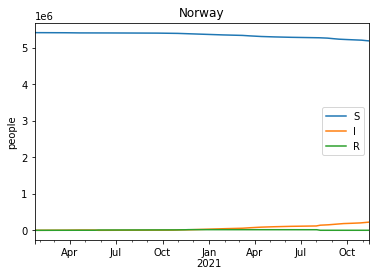

In [70]:
cc_idx = 9
country = list(cc_dict.values())[cc_idx]

S[country].plot()
I[country].plot()
R[country].plot()
plt.ylabel('people')
plt.title(country)
plt.legend(labels=['S', 'I', 'R'])
plt.show()

Extreme spikes appear due to the use of logarithm among with proportional compartments (starting values $\approx 0$).

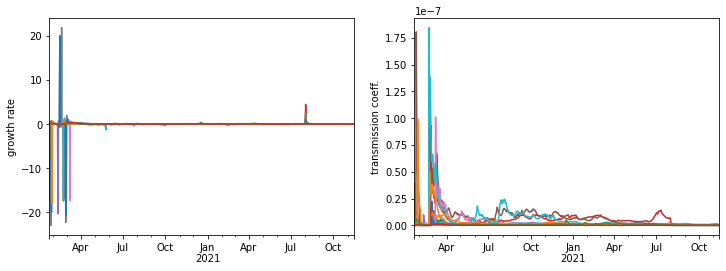

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
plt.show()

Most countries present additional spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low populated countries present various spikes.

Data for each country is considered after the first 25 cases to avoid the initial spikes.

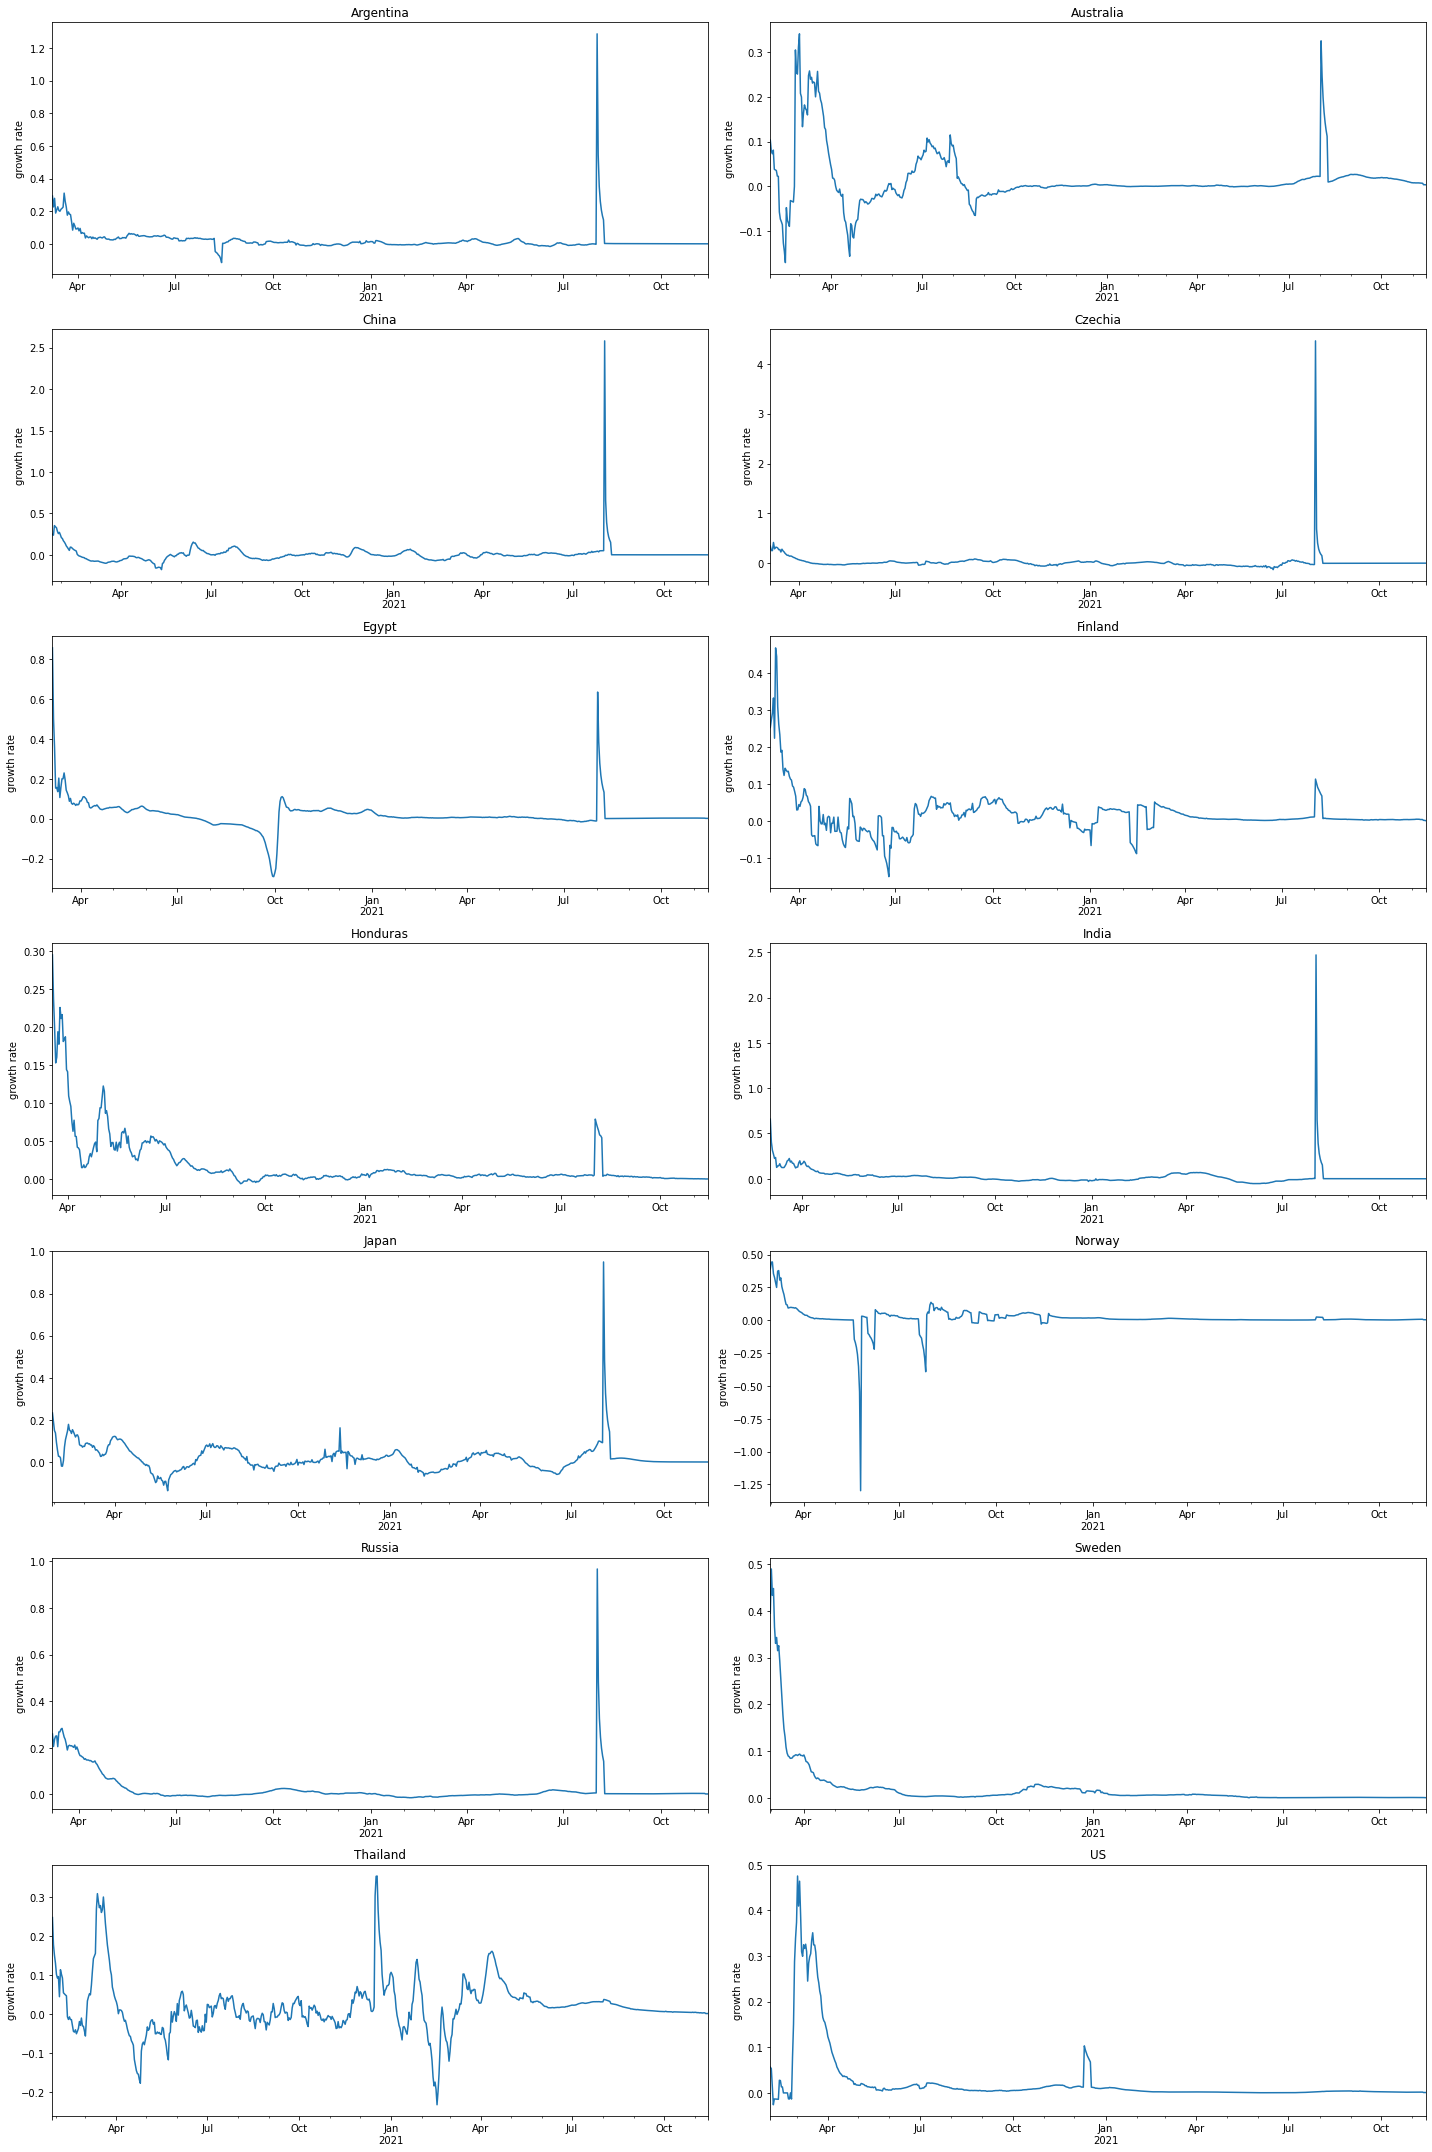

In [72]:
nrows = len(cc_dict) // 2
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname][cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  gr.loc[first:, cname].plot(ax=ax)
  # ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('growth rate')
fig.tight_layout()

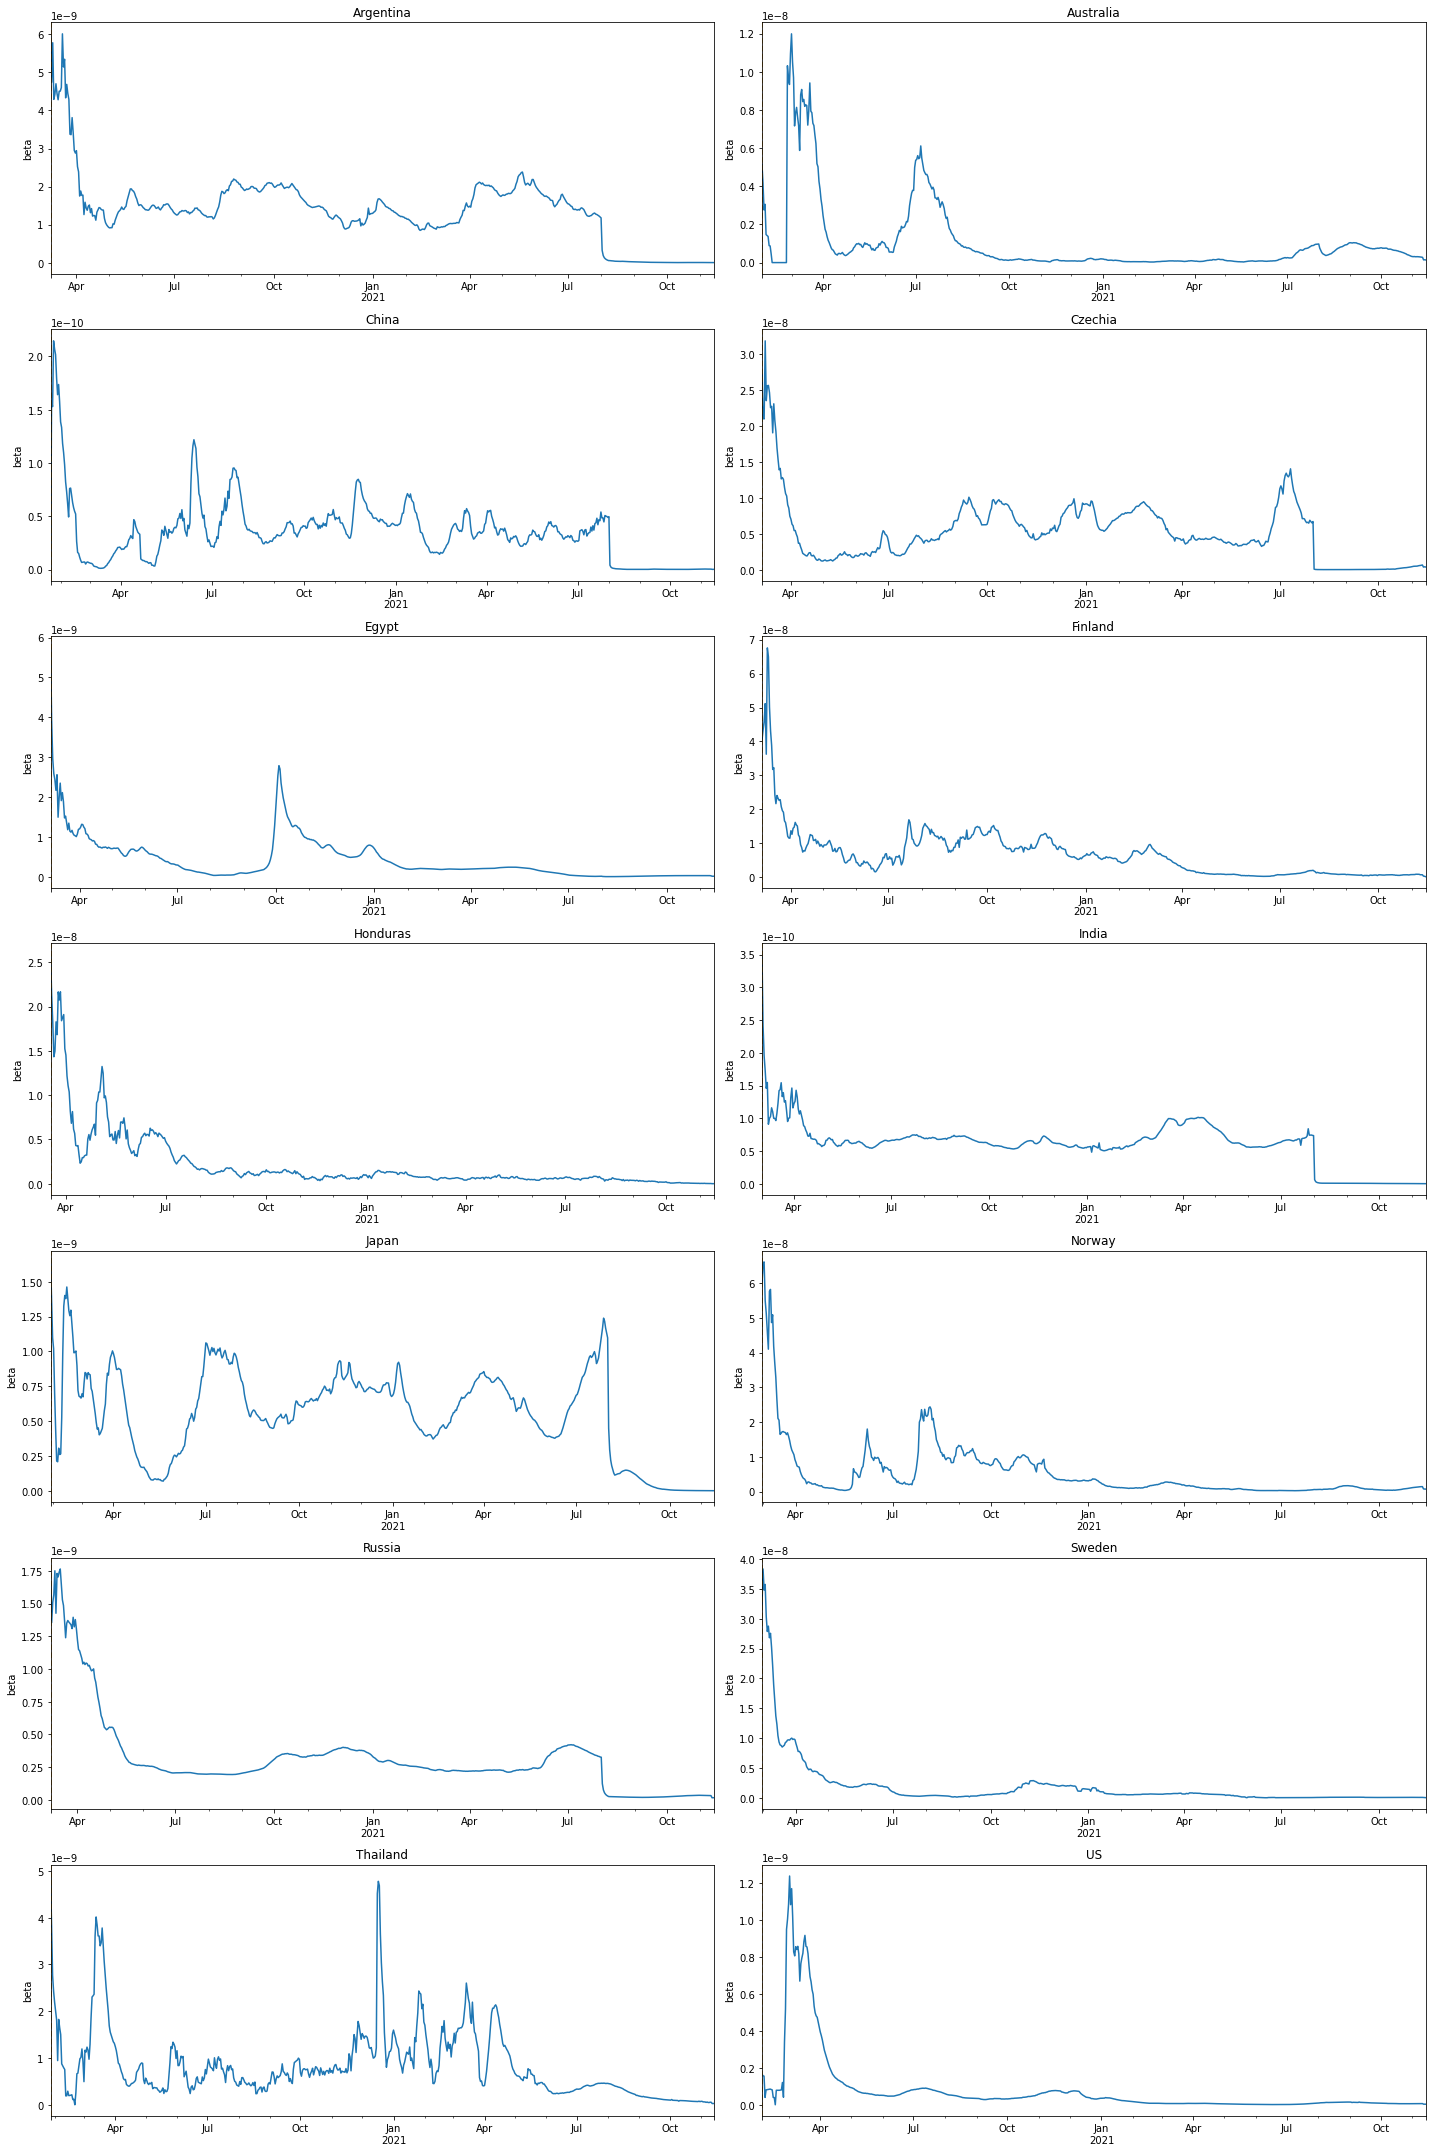

In [73]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta.loc[first:, cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('beta')
fig.tight_layout()

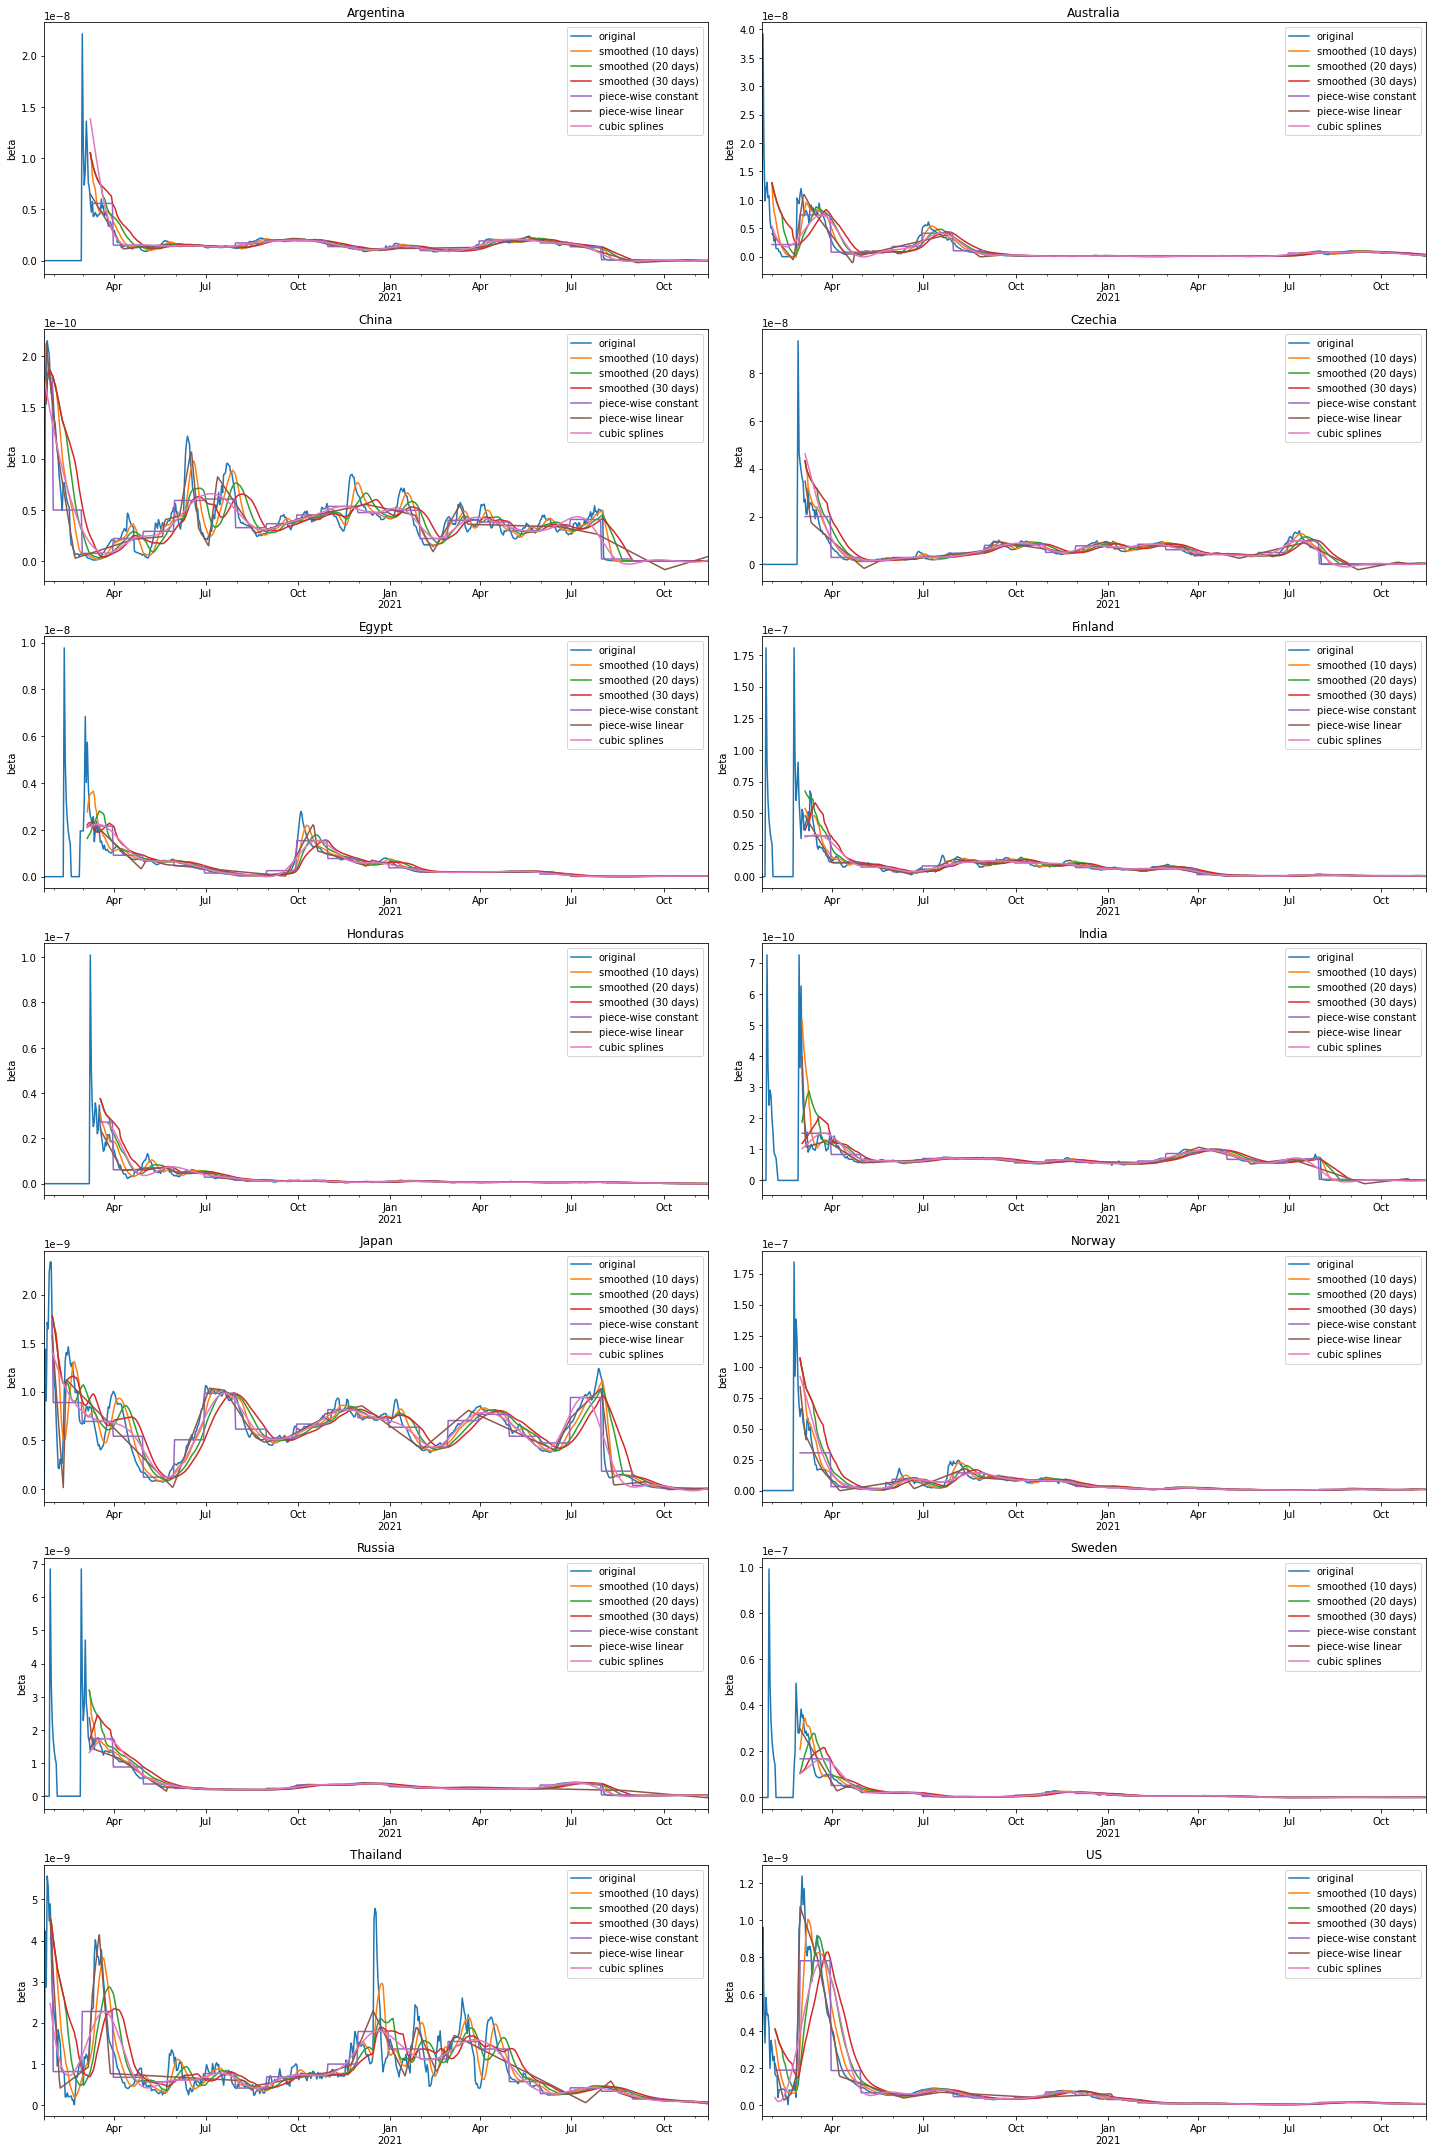

In [74]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta[cname].plot(ax=ax)
  beta_smooth_10.loc[first:, cname].plot(ax=ax)
  beta_smooth_20.loc[first:, cname].plot(ax=ax)
  beta_smooth_30.loc[first:, cname].plot(ax=ax)
  beta_cst.loc[first:, cname].plot(ax=ax)
  beta_lin.loc[first:, cname].plot(ax=ax)
  beta_spl.loc[first:, cname].plot(ax=ax)
  ax.legend([
             'original', 
             'smoothed (10 days)', 'smoothed (20 days)', 'smoothed (30 days)',
             'piece-wise constant', 'piece-wise linear', 'cubic splines'
  ])
  ax.set_title(cname)
  ax.set_ylabel('beta')
fig.tight_layout()

# Missing values

Denoted in `pandas` as *Not a Number* (`NaN`) in numeric columns.

In [75]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())
print(' - H1:', H1[cc_dict.keys()].isna().sum().sum())
print(' - H6:', H6[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 78
 - C2: 82
 - C3: 86
 - C4: 92
 - C5: 85
 - C6: 84
 - C7: 85
 - C8: 85
 - H1: 86
 - H6: 84


In [76]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [77]:
print('Missing values (NaN) in the response')
print(' - growth rate:', gr.isna().sum().sum())
print(' - transmission rate:', beta.isna().sum().sum())

Missing values (NaN) in the response
 - growth rate: 0
 - transmission rate: 0
